### Human Activity Recognition

In [1]:
# found interesting dataset to classify time series data
# Human Activity Recognition (HAR): ts data from 3-axial accelerometer and gyroscope sensors (50 Hz sampling rate)
# sensors in smartphone worn on waist of test subjects as part of a research experiment 
# data at: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
# short summary of expt/data 
# 30 volunteers wearing devices, 70% randomly assigned to training, rest to test dataset
# sensory signals pre-processed by applying noise filters
# then sampled in fixed-width sliding windows of 2.56 sec & 50% overlap (128 readings/window)
# Sensor acceleration data has gravitational and body motion components 
# these separated by Butterworth low-pass filter into body acceleration and gravity
# gravitational force assumed to have only low frequency components, therefore filter with 0.3 Hz cutoff was used
# for each window, a vector of features was obtained by calculating variables from time and freq domain 
# (check features.info.txt for details)

In [3]:
# for each record provided:
# triaxial acceleration from accelerometer (total acceleration) and estimated body acceleration
# triaxial angular velocity from gyroscope
# a 561-feature vector with time and freq domain variables
# its activity label
# an identifier of subject who carried out the expt 

In [4]:
# Dataset included these files:
# readme.txt - stuff from above
# features.info.txt - list of all features
# activity_labels.txt - links class label with their activity name
# train/test data + associated labels files 

In [5]:
# following analysis template as per: https://github.com/jeandeducla/ML-Time-Series
# this repo uses different approaches to ts classification using ml tools 
# in addition to testing different ml models (dl, nn, svm etc), two different types of inputs also tested
# these are raw ts data - or using features extracted from ts (statistical measures, freq domain features etc)
# HAR data for 6 different activities: walking, walking upstairs, walking downstairs, sitting, standing, lying
# each sample in data timeseries is a 2.56 s window sampled at 50 Hz
# which results in 6 x 128 readings per sample 
# ie 3 accelerometer axes x, y, z & 3 gyroscope axes x, y z
# in this repo, we will only use the 3 accelerometer axes x, y, z 
# lets try and plot a sample of each as in the repo info page 

In [ ]:
# did preliminary analysis in earlier files 
# this had last bit with a failed (!) hyperparameter optimization and confusion matrix plots

In [132]:
import numpy as np

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.fftpack import fft, fftfreq
from scipy.signal import argrelextrema
import operator
import scikitplot as skplt

In [3]:
# load body acceleration raw signals 
# x axis
bx_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_acc_x_train.txt')
bx_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_acc_x_test.txt')
# y axis
by_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_acc_y_train.txt')
by_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_acc_y_test.txt')
# z axis
bz_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_acc_z_train.txt')
bz_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_acc_z_test.txt')

In [4]:
# load total acceleration raw signals 
# x axis
tx_train = np.loadtxt('./HARDataset/train/Inertial Signals/total_acc_x_train.txt')
tx_test = np.loadtxt('./HARDataset/test/Inertial Signals/total_acc_x_test.txt')
# y axis
ty_train = np.loadtxt('./HARDataset/train/Inertial Signals/total_acc_y_train.txt')
ty_test = np.loadtxt('./HARDataset/test/Inertial Signals/total_acc_y_test.txt')
# z axis
tz_train = np.loadtxt('./HARDataset/train/Inertial Signals/total_acc_z_train.txt')
tz_test = np.loadtxt('./HARDataset/test/Inertial Signals/total_acc_z_test.txt')

In [5]:
# load body gyroscope raw signals 
# x axis
gx_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_gyro_x_train.txt')
gx_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_gyro_x_test.txt')
# y axis
gy_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_gyro_y_train.txt')
gy_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_gyro_y_test.txt')
# z axis
gz_train = np.loadtxt('./HARDataset/train/Inertial Signals/body_gyro_z_train.txt')
gz_test = np.loadtxt('./HARDataset/test/Inertial Signals/body_gyro_z_test.txt')

In [6]:
bx_train.shape, bx_test.shape

((7352, 128), (2947, 128))

In [7]:
tx_train.shape, tx_test.shape

((7352, 128), (2947, 128))

In [8]:
gx_train.shape, gx_test.shape

((7352, 128), (2947, 128))

In [9]:
# load label vectors
y_train = np.loadtxt('./HARDataset/train/y_train.txt')
y_test = np.loadtxt('./HARDataset/test/y_test.txt')

In [10]:
y_train.shape, y_test.shape

((7352,), (2947,))

### Statistical and area features

In [12]:
def stat_area_features(x, Te=1.0):
    # mean
    mean_ts = np.mean(x, axis=1).reshape(-1, 1)
    # max
    max_ts = np.amax(x, axis=1).reshape(-1, 1)
    # min
    min_ts = np.amin(x, axis=1).reshape(-1, 1)
    # std
    std_ts = np.std(x, axis=1).reshape(-1, 1)
    # skew
    skew_ts = st.skew(x, axis=1).reshape(-1, 1)
    # kurtosis
    kurtosis_ts = st.kurtosis(x, axis=1).reshape(-1, 1)
    # interquartile range
    iqr_ts = st.iqr(x, axis=1).reshape(-1, 1)
    # median absolute deviation
    mad_ts = np.median(np.sort(abs(x - np.mean(x, axis=1).reshape(-1, 1)), axis=1), axis=1).reshape(-1, 1)
    # area under curve
    area_ts = np.trapz(x, axis=1, dx=Te).reshape(-1, 1)
    # area under curve ** 2
    sq_area_ts = np.trapz(x ** 2, axis=1, dx=Te).reshape(-1, 1)
    
    return np.concatenate((mean_ts, max_ts, min_ts, std_ts, skew_ts, kurtosis_ts, iqr_ts, 
                           mad_ts, area_ts, sq_area_ts), axis=1)

In [13]:
# stats for train data

In [14]:
bx_train_stats = stat_area_features(bx_train)
by_train_stats = stat_area_features(by_train)
bz_train_stats = stat_area_features(bz_train)

In [15]:
bx_train_stats.shape, by_train_stats.shape, bz_train_stats.shape

((7352, 10), (7352, 10), (7352, 10))

In [16]:
tx_train_stats = stat_area_features(tx_train)
ty_train_stats = stat_area_features(ty_train)
tz_train_stats = stat_area_features(tz_train)

In [17]:
tx_train_stats.shape, ty_train_stats.shape, tz_train_stats.shape

((7352, 10), (7352, 10), (7352, 10))

In [18]:
gx_train_stats = stat_area_features(gx_train)
gy_train_stats = stat_area_features(gy_train)
gz_train_stats = stat_area_features(gz_train)

In [19]:
gx_train_stats.shape, gy_train_stats.shape, gz_train_stats.shape

((7352, 10), (7352, 10), (7352, 10))

In [20]:
# stats for test data

In [21]:
bx_test_stats = stat_area_features(bx_test)
by_test_stats = stat_area_features(by_test)
bz_test_stats = stat_area_features(bz_test)

In [22]:
bx_test_stats.shape, by_test_stats.shape, bz_test_stats.shape

((2947, 10), (2947, 10), (2947, 10))

In [23]:
tx_test_stats = stat_area_features(tx_test)
ty_test_stats = stat_area_features(ty_test)
tz_test_stats = stat_area_features(tz_test)

In [24]:
tx_test_stats.shape, ty_test_stats.shape, tz_test_stats.shape

((2947, 10), (2947, 10), (2947, 10))

In [25]:
gx_test_stats = stat_area_features(gx_test)
gy_test_stats = stat_area_features(gy_test)
gz_test_stats = stat_area_features(gz_test)

In [26]:
gx_test_stats.shape, gy_test_stats.shape, gz_test_stats.shape

((2947, 10), (2947, 10), (2947, 10))

In [27]:
# jerk for train data (first derivative)

In [28]:
bx_train_jerk = stat_area_features((bx_train[:, 1:] - bx_train[:, :-1])/1.0)
by_train_jerk = stat_area_features((by_train[:, 1:] - by_train[:, :-1])/1.0)
bz_train_jerk = stat_area_features((bz_train[:, 1:] - bz_train[:, :-1])/1.0)

In [29]:
bx_train_jerk.shape, by_train_jerk.shape, bz_train_jerk.shape

((7352, 10), (7352, 10), (7352, 10))

In [30]:
tx_train_jerk = stat_area_features((tx_train[:, 1:] - tx_train[:, :-1])/1.0)
ty_train_jerk = stat_area_features((ty_train[:, 1:] - ty_train[:, :-1])/1.0)
tz_train_jerk = stat_area_features((tz_train[:, 1:] - tz_train[:, :-1])/1.0)

In [31]:
tx_train_jerk.shape, ty_train_jerk.shape, tz_train_jerk.shape

((7352, 10), (7352, 10), (7352, 10))

In [32]:
gx_train_jerk = stat_area_features((gx_train[:, 1:] - gx_train[:, :-1])/1.0)
gy_train_jerk = stat_area_features((gy_train[:, 1:] - gy_train[:, :-1])/1.0)
gz_train_jerk = stat_area_features((gz_train[:, 1:] - gz_train[:, :-1])/1.0)

In [33]:
gx_train_jerk.shape, gy_train_jerk.shape, gz_train_jerk.shape

((7352, 10), (7352, 10), (7352, 10))

In [34]:
# jerk for test data (first derivative)

In [35]:
bx_test_jerk = stat_area_features((bx_test[:, 1:] - bx_test[:, :-1])/1.0)
by_test_jerk = stat_area_features((by_test[:, 1:] - by_test[:, :-1])/1.0)
bz_test_jerk = stat_area_features((bz_test[:, 1:] - bz_test[:, :-1])/1.0)

In [36]:
bx_test_jerk.shape, by_test_jerk.shape, bz_test_jerk.shape

((2947, 10), (2947, 10), (2947, 10))

In [37]:
tx_test_jerk = stat_area_features((tx_test[:, 1:] - tx_test[:, :-1])/1.0)
ty_test_jerk = stat_area_features((ty_test[:, 1:] - ty_test[:, :-1])/1.0)
tz_test_jerk = stat_area_features((tz_test[:, 1:] - tz_test[:, :-1])/1.0)

In [38]:
tx_test_jerk.shape, ty_test_jerk.shape, tz_test_jerk.shape

((2947, 10), (2947, 10), (2947, 10))

In [39]:
gx_test_jerk = stat_area_features((gx_test[:, 1:] - gx_test[:, :-1])/1.0)
gy_test_jerk = stat_area_features((gy_test[:, 1:] - gy_test[:, :-1])/1.0)
gz_test_jerk = stat_area_features((gz_test[:, 1:] - gz_test[:, :-1])/1.0)

In [40]:
gx_test_jerk.shape, gy_test_jerk.shape, gz_test_jerk.shape

((2947, 10), (2947, 10), (2947, 10))

### Discrete Fourier Transform features 

In [41]:
def frequency_domain_features(x, Te=1.0):
    
    # as DFT coefficients and their corresponding frequencies are symetrical arrays with respect to
    # the middle of the array, need to control for whether samples in x are odd or even to then split arrays
    if x.shape[1]%2 == 0:
        N = int(x.shape[1]/2)
    else: 
        N = int(x.shape[1]/2) - 1
    xf = np.repeat(fftfreq(x.shape[1], d=1.0)[:N].reshape(1, -1), x.shape[0], axis=0) # frequencies
    dft = np.abs(fft(x, axis=1))[:, :N] # DFT coefficients
    
    # stat and area features
    dft_features = stat_area_features(dft)
    # weighted mean freq
    dft_weighted_mean_f = np.average(xf, axis=1, weights=dft).reshape(-1, 1)
    # first 5 DFT coefficients
    dft_first_coeff = dft[:, :5]
    # first 5 local maxima of DFT coefficients and their corresponding frequencies
    dft_max_coeff = np.zeros((x.shape[0], 5))
    dft_max_coeff_f = np.zeros((x.shape[0], 5))
    for row in range(x.shape[0]):
        # find indexes of all local maximas
        extrema_indiv = argrelextrema(dft[row, :], np.greater, axis=0)
        # make list of tuples (DFT_i, f_i) of all local maxima
        extrema_row = sorted([(dft[row, :][j], xf[row, j]) for j in extrema_indiv[0]],
                             key=operator.itemgetter(0), reverse=True)[:5]
        for i, ext in enumerate(extrema_row):
            dft_max_coeff[row, i] = ext[0]
            dft_max_coeff_f[row, i] = ext[1]
    
    return np.concatenate((dft_features, dft_weighted_mean_f, dft_first_coeff, 
                           dft_max_coeff, dft_max_coeff_f), axis=1)

In [42]:
# dft for train data

In [43]:
bx_train_dft = frequency_domain_features(bx_train)
by_train_dft = frequency_domain_features(by_train)
bz_train_dft = frequency_domain_features(bz_train)

In [44]:
bx_train_dft.shape, by_train_dft.shape, bz_train_dft.shape

((7352, 26), (7352, 26), (7352, 26))

In [45]:
tx_train_dft = frequency_domain_features(tx_train)
ty_train_dft = frequency_domain_features(ty_train)
tz_train_dft = frequency_domain_features(tz_train)

In [46]:
tx_train_dft.shape, ty_train_dft.shape, tz_train_dft.shape

((7352, 26), (7352, 26), (7352, 26))

In [47]:
gx_train_dft = frequency_domain_features(gx_train)
gy_train_dft = frequency_domain_features(gy_train)
gz_train_dft = frequency_domain_features(gz_train)

In [48]:
gx_train_dft.shape, gy_train_dft.shape, gz_train_dft.shape

((7352, 26), (7352, 26), (7352, 26))

In [49]:
# dft for test data

In [50]:
bx_test_dft = frequency_domain_features(bx_test)
by_test_dft = frequency_domain_features(by_test)
bz_test_dft = frequency_domain_features(bz_test)

In [51]:
bx_test_dft.shape, by_test_dft.shape, bz_test_dft.shape

((2947, 26), (2947, 26), (2947, 26))

In [52]:
tx_test_dft = frequency_domain_features(tx_test)
ty_test_dft = frequency_domain_features(ty_test)
tz_test_dft = frequency_domain_features(tz_test)

In [53]:
tx_test_dft.shape, ty_test_dft.shape, tz_test_dft.shape

((2947, 26), (2947, 26), (2947, 26))

In [54]:
gx_test_dft = frequency_domain_features(gx_test)
gy_test_dft = frequency_domain_features(gy_test)
gz_test_dft = frequency_domain_features(gz_test)

In [55]:
gx_test_dft.shape, gy_test_dft.shape, gz_test_dft.shape

((2947, 26), (2947, 26), (2947, 26))

In [56]:
# dft_jerk for train data (first derivative)

In [57]:
bx_train_dft_jerk = frequency_domain_features((bx_train[:, 1:] - bx_train[:, :-1])/1.0)
by_train_dft_jerk = frequency_domain_features((by_train[:, 1:] - by_train[:, :-1])/1.0)
bz_train_dft_jerk = frequency_domain_features((bz_train[:, 1:] - bz_train[:, :-1])/1.0)

In [58]:
bx_train_dft_jerk.shape, by_train_dft_jerk.shape, bz_train_dft_jerk.shape

((7352, 26), (7352, 26), (7352, 26))

In [59]:
tx_train_dft_jerk = frequency_domain_features((tx_train[:, 1:] - tx_train[:, :-1])/1.0)
ty_train_dft_jerk = frequency_domain_features((ty_train[:, 1:] - ty_train[:, :-1])/1.0)
tz_train_dft_jerk = frequency_domain_features((tz_train[:, 1:] - tz_train[:, :-1])/1.0)

In [60]:
tx_train_dft_jerk.shape, ty_train_dft_jerk.shape, tz_train_dft_jerk.shape

((7352, 26), (7352, 26), (7352, 26))

In [61]:
gx_train_dft_jerk = frequency_domain_features((gx_train[:, 1:] - gx_train[:, :-1])/1.0)
gy_train_dft_jerk = frequency_domain_features((gy_train[:, 1:] - gy_train[:, :-1])/1.0)
gz_train_dft_jerk = frequency_domain_features((gz_train[:, 1:] - gz_train[:, :-1])/1.0)

In [62]:
gx_train_dft_jerk.shape, gy_train_dft_jerk.shape, gz_train_dft_jerk.shape

((7352, 26), (7352, 26), (7352, 26))

In [63]:
# dft_jerk for test data (first derivative)

In [64]:
bx_test_dft_jerk = frequency_domain_features((bx_test[:, 1:] - bx_test[:, :-1])/1.0)
by_test_dft_jerk = frequency_domain_features((by_test[:, 1:] - by_test[:, :-1])/1.0)
bz_test_dft_jerk = frequency_domain_features((bz_test[:, 1:] - bz_test[:, :-1])/1.0)

In [65]:
bx_test_dft_jerk.shape, by_test_dft_jerk.shape, bz_test_dft_jerk.shape

((2947, 26), (2947, 26), (2947, 26))

In [66]:
tx_test_dft_jerk = frequency_domain_features((tx_test[:, 1:] - tx_test[:, :-1])/1.0)
ty_test_dft_jerk = frequency_domain_features((ty_test[:, 1:] - ty_test[:, :-1])/1.0)
tz_test_dft_jerk = frequency_domain_features((tz_test[:, 1:] - tz_test[:, :-1])/1.0)

In [67]:
tx_test_dft_jerk.shape, ty_test_dft_jerk.shape, tz_test_dft_jerk.shape

((2947, 26), (2947, 26), (2947, 26))

In [68]:
gx_test_dft_jerk = frequency_domain_features((gx_test[:, 1:] - gx_test[:, :-1])/1.0)
gy_test_dft_jerk = frequency_domain_features((gy_test[:, 1:] - gy_test[:, :-1])/1.0)
gz_test_dft_jerk = frequency_domain_features((gz_test[:, 1:] - gz_test[:, :-1])/1.0)

In [69]:
gx_test_dft_jerk.shape, gy_test_dft_jerk.shape, gz_test_dft_jerk.shape

((2947, 26), (2947, 26), (2947, 26))

### correlation coefficients for raw signals between axis

In [71]:
def corr_coeffs(x, y, z):
    corr = np.empty((x.shape[0], 3))
    for row in range(x.shape[0]):
        xyz_matrix = np.concatenate((x[row, :].reshape(1, -1), y[row, :].reshape(1, -1), 
                                     z[row, :].reshape(1, -1)), axis=0)
        corr[row, 0] = np.corrcoef(xyz_matrix)[0, 1]
        corr[row, 1] = np.corrcoef(xyz_matrix)[0, 2]
        corr[row, 2] = np.corrcoef(xyz_matrix)[1, 2]
        
    return corr 

In [72]:
corr_b_train = corr_coeffs(bx_train, by_train, bz_train)
corr_t_train = corr_coeffs(tx_train, ty_train, tz_train)
corr_g_train = corr_coeffs(gx_train, gy_train, gz_train)

In [73]:
corr_b_train.shape, corr_t_train.shape, corr_g_train.shape

((7352, 3), (7352, 3), (7352, 3))

In [74]:
corr_b_test = corr_coeffs(bx_test, by_test, bz_test)
corr_t_test = corr_coeffs(tx_test, ty_test, tz_test)
corr_g_test = corr_coeffs(gx_test, gy_test, gz_test)

In [75]:
corr_b_test.shape, corr_t_test.shape, corr_g_test.shape

((2947, 3), (2947, 3), (2947, 3))

In [76]:
# creating X_train and X_test 

In [77]:
X_train = np.concatenate((bx_train_stats, by_train_stats, bz_train_stats, 
                          tx_train_stats, ty_train_stats, tz_train_stats, 
                          gx_train_stats, gy_train_stats, gz_train_stats, 
                          bx_train_jerk, by_train_jerk, bz_train_jerk, 
                          tx_train_jerk, ty_train_jerk, tz_train_jerk, 
                          gx_train_jerk, gy_train_jerk, gz_train_jerk,
                          bx_train_dft, by_train_dft, bz_train_dft, 
                          tx_train_dft, ty_train_dft, tz_train_dft, 
                          gx_train_dft, gy_train_dft, gz_train_dft, 
                          bx_train_dft_jerk, by_train_dft_jerk, bz_train_dft_jerk, 
                          tx_train_dft_jerk, ty_train_dft_jerk, tz_train_dft_jerk, 
                          gx_train_dft_jerk, gy_train_dft_jerk, gz_train_dft_jerk, 
                          corr_b_train, corr_t_train, corr_g_train), axis=1)

In [78]:
X_test = np.concatenate((bx_test_stats, by_test_stats, bz_test_stats, 
                          tx_test_stats, ty_test_stats, tz_test_stats, 
                          gx_test_stats, gy_test_stats, gz_test_stats, 
                          bx_test_jerk, by_test_jerk, bz_test_jerk, 
                          tx_test_jerk, ty_test_jerk, tz_test_jerk, 
                          gx_test_jerk, gy_test_jerk, gz_test_jerk,
                          bx_test_dft, by_test_dft, bz_test_dft, 
                          tx_test_dft, ty_test_dft, tz_test_dft, 
                          gx_test_dft, gy_test_dft, gz_test_dft, 
                          bx_test_dft_jerk, by_test_dft_jerk, bz_test_dft_jerk, 
                          tx_test_dft_jerk, ty_test_dft_jerk, tz_test_dft_jerk, 
                          gx_test_dft_jerk, gy_test_dft_jerk, gz_test_dft_jerk, 
                          corr_b_test, corr_t_test, corr_g_test), axis=1)

In [79]:
X_train.shape, X_test.shape 

((7352, 657), (2947, 657))

### SVM

In [81]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [135]:
svm = svm.SVC()

In [136]:
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [137]:
svm.score(X_train, y_train) # adding corr 0.9838 to 0.9857

0.9857181719260065

In [138]:
y_pred_svm = svm.predict(X_test)

In [139]:
print(classification_report(y_test, y_pred_svm)) # adding corr 0.96 to 0.96 

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       496
         2.0       0.99      0.99      0.99       471
         3.0       0.98      0.98      0.98       420
         4.0       0.90      0.89      0.90       491
         5.0       0.91      0.90      0.91       532
         6.0       0.99      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



### Hyperparameter Optimization (failed!)

In [87]:
# hyperparameter optimization of SVM with Radial Basis Function (RBF) kernel 
# two paramters: gamma and C of RBF
# gamma: defines how far influence of single training example reaches (low values=far, high=close)
# gamma like inverse of radius of influence of samples selected by model as support vectors 
# C: trades off correct classification of training samples against maximization of decision function's margin 
# larger C: smaller margin accepted if decision function is better classifying all training points correctly
# lower C: encourages larger margin, so simpler decision function at cost of training accuracy
# C behaves as a regularization parameter in SVM 

In [88]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.01, 0.1, 1, 10, 100, 1000]}

In [89]:
clf = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1)

In [90]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [92]:
# best hyperparameters:

clf.best_params_

{'C': 10, 'gamma': 0.01}

In [93]:
# Running SVM with these hyperparameters

In [127]:
svm2 = svm.SVC(C=10, gamma=0.01)

In [128]:
svm2.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [129]:
svm2.score(X_train, y_train) # adding corr 0.9857 to 1.0 

1.0

In [130]:
y_pred_svm2 = svm2.predict(X_test)

In [131]:
print(classification_report(y_test, y_pred_svm2)) # adding corr 0.96 to 0.82: this is significantly worse!!! 

              precision    recall  f1-score   support

         1.0       0.99      0.72      0.83       496
         2.0       0.91      0.73      0.81       471
         3.0       0.48      0.92      0.63       420
         4.0       0.91      0.82      0.87       491
         5.0       0.91      0.83      0.87       532
         6.0       1.00      0.90      0.94       537

    accuracy                           0.82      2947
   macro avg       0.87      0.82      0.82      2947
weighted avg       0.88      0.82      0.83      2947



In [133]:
# why oh why? will stick to original SVC for confusion matrix

### Confusion Matrix

In [155]:
# for training data

In [142]:
predictions_svm_train = cross_val_predict(svm, X_train, y_train)

In [143]:
confusion_matrix(y_train, predictions_svm_train)

array([[1140,   59,   27,    0,    0,    0],
       [  47,  992,   34,    0,    0,    0],
       [   6,   29,  948,    0,    0,    3],
       [   0,    1,    0, 1131,  137,   17],
       [   0,    0,    0,  141, 1233,    0],
       [   0,    0,    2,    1,    0, 1404]])

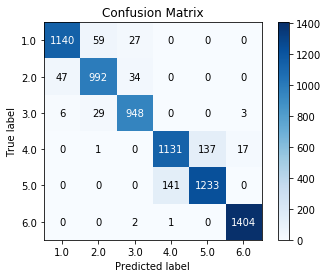

In [161]:
skplt.metrics.plot_confusion_matrix(y_train, predictions_svm_train)

In [162]:
# for testing data

In [163]:
predictions_svm_test = cross_val_predict(svm, X_test, y_test)

In [164]:
confusion_matrix(y_test, predictions_svm_test)

array([[477,   2,  17,   0,   0,   0],
       [  1, 467,   3,   0,   0,   0],
       [  5,  30, 385,   0,   0,   0],
       [  0,   0,   1, 432,  57,   1],
       [  0,   0,   0,  70, 462,   0],
       [  0,   0,   1,   0,   0, 536]])

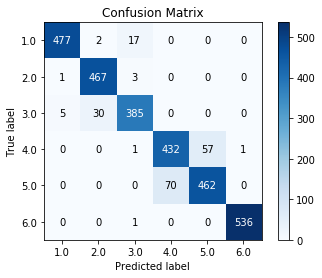

In [165]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_svm_test)

In [166]:
# looks fairly good

In [ ]:
# stuff to do: 
# a function to load all data and process it 
# CNN to do same classification